#Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом: 
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

In [1]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 5.1 MB/s 
     |████████████████████████████████| 512 kB 23.5 MB/s 
     |████████████████████████████████| 125 kB 52.6 MB/s 


Скачаем данные

In [2]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

total 12
drwx------ 4 root root 4096 Nov 26 08:32 data
drwxr-xr-x 3 root root 4096 Dec 19 10:12 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 16 00:01 sample_data


Посмотрим как выглядит один из файлов разметки

In [3]:
!cat data/train/apple_3.xml

<annotation>
	<folder>train</folder>
	<filename>apple_3.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_3.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1000</width>
		<height>708</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>584</xmin>
			<ymin>438</ymin>
			<xmax>867</xmax>
			<ymax>708</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>492</xmin>
			<ymin>141</ymin>
			<xmax>740</xmax>
			<ymax>394</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>176</xmin>
			<ymin>199</ymin>
			<xmax>490</xmax>
			<ymax>466</ymax>
		</bndbox>
	</object>
	<obj

## Релизуйте выборку для YoloV1 - 2 балла

In [4]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.6 MB/s 
     |████████████████████████████████| 174 kB 72.3 MB/s 
     |████████████████████████████████| 182 kB 47.9 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 173 kB 55.6 MB/s 
     |████████████████████████████████| 168 kB 54.4 MB/s 
     |████████████████████████████████| 168 kB 55.8 MB/s 
     |████████████████████████████████| 166 kB 52.5 MB/s 
     |████████████████████████████████| 166 kB 52.1 MB/s 
     |████████████████████████████████| 162 kB 50.9 MB/s 
     |████████████████████████████████| 162 kB 54.8 MB/s 
     |████████████████████████████████| 158 kB 15.5 MB/s 
     |████████████████████████████████| 157 kB 53.9 MB/s 
     |████████████████████████████████| 157 kB 52.9 MB/s 
     |████████████████████████████████| 157 kB 52.3 MB/s 
     |████████████████████████████

In [5]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict
import random

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image
from matplotlib.patches import Rectangle
from PIL import ImageDraw, ImageFont
from IPython.display import display

import matplotlib.pyplot as plt

from sklearn.metrics import auc

import wandb
from pytorch_lightning.loggers import WandbLogger
wandb.login(key='0b484be923497ee3dfd420ede5e381f8b32e3721')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(123456)

Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

In [7]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.image_paths = sorted(glob.glob(os.path.join(data_dir, "*.jpg")))
        self.box_paths = sorted(glob.glob(os.path.join(data_dir, "*.xml")))

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"), dtype='float32')
        boxes, class_labels = self.__get_boxes_from_xml(self.box_paths[idx])

        im_w = Image.open(self.image_paths[idx]).convert("RGB").width
        im_h = Image.open(self.image_paths[idx]).convert("RGB").height

        for i in range(len(boxes)):
            boxes[i] = self.__convert_to_yolo_box_params(boxes[i], im_w, im_h)

        if self.transforms:
            image = self.transforms(image=image, bboxes=boxes, class_labels=class_labels)['image']
        
        for i in range(len(class_labels)):
            a = [0, 0, 0]
            a[class_labels[i]-1] = 1
            class_labels[i] = a

        target_tensor = torch.zeros(7, 7, 13)

        for box in boxes:
            for i in range(7):
                if np.ceil(box[0]*7) == i:
                    for j in range(7):
                        if np.ceil(box[1]*7) == j:
                            target_tensor[i][j][0:5] = torch.tensor(box)
                            target_tensor[i][j][5:10] = torch.tensor(box)  
                            target_tensor[i][j][10:] = torch.tensor(class_labels[boxes.index(box)])

        return image / 255, target_tensor

    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str):
        """
        Метод, который считает и распарсит (с помощью xmltodict) переданный xml
        файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
        и название класса обьекта в каждом прямоугольнике

        Обратите внимание, что обьектов может быть как несколько, так и один единственный
        """
        boxes = []
        class_labels = []

        with open(xml_filename) as fd:
            doc = xmltodict.parse(fd.read())
            if type(doc['annotation']['object']) is dict:
                class_labels.append(class2tag[doc['annotation']['object']['name']])
                boxes.append(list(map(int, list(doc['annotation']['object']['bndbox'].values()))))
            else:
                for i in range(len(doc['annotation']['object'])):
                    class_labels.append(class2tag[doc['annotation']['object'][i]['name']])
                    boxes.append(list(map(int, list(doc['annotation']['object'][i]['bndbox'].values()))))

        return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
        """
        Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].
        
        Обратите внимание, что параметры [x_center, y_center, width, height] - это
        относительные значение в отрезке [0, 1]

        :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
        :param: im_w - ширина исходного изображения
        :param: im_h - высота исходного изображения

        :return: координаты коробки в формате [x_center, y_center, width, height]
        """
        ans = []

        ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
        ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center
      
        ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
        ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height

        ans.append(1)

        return ans

In [8]:
train_transform = A.Compose([A.Resize(height=448, width=448), 
                             A.ColorJitter(0.2),
                             A.HorizontalFlip(p=0.2),
                             A.VerticalFlip(p=0.2), 
                             A.pytorch.transforms.ToTensorV2()], 
                             bbox_params=A.BboxParams(format='yolo', 
                                                      label_fields=['class_labels']))
test_transform = A.Compose([A.Resize(height=448, width=448), A.pytorch.transforms.ToTensorV2()], 
                            bbox_params=A.BboxParams(format='yolo',
                                                     label_fields=['class_labels']))

In [9]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="./data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="./data/test"
    )

# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены")

Тесты успешно пройдены


In [10]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= 4,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4, 
    shuffle=False
    )

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [11]:
def intersection_over_union(predicted_bbox, gt_bbox) -> float:
    """
    Intersection Over Union для двух прямоугольников

    :param: predicted_bbox - [x_min, y_min, x_max, y_max]
    :param: gt_bbox - [x_min, y_min, x_max, y_max]
    
    :return: Intersection Over Union
    """
    predicted_bbox = predicted_bbox.cpu().detach().numpy()
    gt_bbox = gt_bbox.cpu().detach().numpy()

    pr_x_min = predicted_bbox[0] - predicted_bbox[2] / 2
    pr_y_min = predicted_bbox[1] - predicted_bbox[3] / 2
    pr_x_max = predicted_bbox[0] + predicted_bbox[2] / 2
    pr_y_max = predicted_bbox[1] + predicted_bbox[3] / 2
    
    gt_x_min = gt_bbox[0] - gt_bbox[2] / 2
    gt_y_min = gt_bbox[1] - gt_bbox[3] / 2
    gt_x_max = gt_bbox[0] + gt_bbox[2] / 2
    gt_y_max = gt_bbox[1] + gt_bbox[3] / 2

    predicted_bbox = [pr_x_min, pr_y_min, pr_x_max, pr_y_max]
    gt_bbox = [gt_x_min, gt_y_min, gt_x_max, gt_y_max]
    
    intersection_bbox = np.array(
        [
            max(predicted_bbox[0], gt_bbox[0]),
            max(predicted_bbox[1], gt_bbox[1]),
            min(predicted_bbox[2], gt_bbox[2]),
            min(predicted_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (predicted_bbox[2] - predicted_bbox[0]) * (predicted_bbox[3] - predicted_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете. 

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

Таким образом, мы для каждого окна размера __S x S__ предсказываем __В__ коробо и один класс

In [12]:
class CNNBlock(nn.Module):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, is_max_pool:bool=False, **kwargs):
        
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x
    
class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C

        self.b1_3 = nn.Sequential(
            CNNBlock(3, 64, is_max_pool=True, kernel_size=7, stride=2),
            CNNBlock(64, 192, is_max_pool=True, kernel_size=3),

            CNNBlock(192, 128, kernel_size=1),
            CNNBlock(128, 256, kernel_size=3),
            CNNBlock(256, 256, kernel_size=1),
            CNNBlock(256, 512, is_max_pool=True, kernel_size=3),
        )
        self.b4x4 = nn.Sequential(
            CNNBlock(512, 256, kernel_size=1),
            CNNBlock(256, 512, kernel_size=3)
        )
        self.b4_2 = nn.Sequential(
            CNNBlock(512, 512, kernel_size=1),
            CNNBlock(512, 1024, is_max_pool=True, kernel_size=3)
        )
        self.b5x2 = nn.Sequential(
            CNNBlock(1024, 512, kernel_size=1),
            CNNBlock(512, 1024, kernel_size=3)
        )
        self.b5_2 = nn.Sequential(
            CNNBlock(1024, 1024, kernel_size=3, padding=2),
            CNNBlock(1024, 1024, kernel_size=3, stride=2, padding=2)
        )
        self.b6x2 = nn.Sequential(
            CNNBlock(1024, 1024, kernel_size=3, padding=2)
        )
        self.fc1_2 = nn.Sequential(nn.Linear(65536, 2048),
                                   nn.Dropout(0.1),
                                   nn.LeakyReLU(0.1),
                                   nn.Linear(2048, self.S * self.S * (self.B * 5 + self.C))
        )


    def forward(self, x):
        x = self.b1_3(x)

        x = self.b4x4(x)
        x = self.b4x4(x)
        x = self.b4x4(x)
        x = self.b4x4(x)

        x = self.b4_2(x)

        x = self.b5x2(x)
        x = self.b5x2(x)

        x = self.b5_2(x)

        x = self.b6x2(x)
        x = self.b6x2(x)

        x = nn.Flatten()(x)

        x = self.fc1_2(x)

        return x

temp_model = YOLO()
expected_output_shape = temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)

assert temp_model(train_dataset[0][0].unsqueeze(0)).reshape(-1).shape[0] == train_dataset[0][1].reshape(-1).shape[0]
assert temp_model(train_dataset[0][0].unsqueeze(0)).reshape(-1).shape[0] == expected_output_shape

## Реализуйте YoloLoss - 3 балла

x, y, w, h, 1, x, y, w, h, 1, p1, p2, p3

In [13]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)
        loss = 0
        for n in range(predictions.size()[0]):
            loss1, loss2, loss3, loss4, loss5 = 0, 0, 0, 0, 0
            for i in range(self.S):
                for j in range(self.S):
                    if target[n][i][j][4] == 1:
                        obj = 1
                        if intersection_over_union(predictions[n][i][j][:4], target[n][i][j][:4]) > intersection_over_union(predictions[n][i][j][5:9], target[n][i][j][5:9]):
                            n_box = 0
                        else:
                            n_box = 1
                    else:
                        obj = 0
                    if obj: 
                        loss1 += obj * (self.mse(predictions[n][i][j][0+n_box*5], target[n][i][j][0]) + self.mse(predictions[n][i][j][1+n_box*5], target[n][i][j][1]))
                        loss2 += obj * (self.mse(torch.sign(predictions[n][i][j][2+n_box*5])*torch.sqrt(torch.abs(predictions[n][i][j][2+n_box*5])), torch.sqrt(target[n][i][j][2])) + self.mse(torch.sign(predictions[n][i][j][3+n_box*5])*torch.sqrt(torch.abs(predictions[n][i][j][3+n_box*5])), torch.sqrt(target[n][i][j][3])))
                        loss3 += obj * (self.mse(predictions[n][i][j][4+n_box*5], target[n][i][j][4]))
                    else:
                        for n_box in range(self.B):
                            loss4 += (1-obj) * (self.mse(predictions[n][i][j][4+n_box*5], target[n][i][j][4]))
                    
                    for k in range(self.C):
                        loss5 += obj * self.mse(predictions[n][i][j][10+k], target[n][i][j][10+k])
                 
            loss += self.lambda_coord * (loss1 + loss2) + loss3 + self.lambda_noobj * loss4 + loss5

        return loss / predictions.size()[0] #считаю лосс средний по батчу

## Реализуйте дополнительные функции из статьи - 2 балла

In [14]:
#https://medium.com/analytics-vidhya/non-max-suppression-nms-6623e6572536
def non_max_suppression(bboxes, iou_threshold, threshold):
    bbox_list_thresholded = []
    bbox_list_new = []
    
    for i in range(7):
        for j in range(7):
            for b in range(2):
                if bboxes[i][j][4+b*5] > threshold:
                    bbox_list_thresholded.append([bboxes[i][j][0+b*5:5+b*5], bboxes[i][j][10:]])
                    
    bbox_list_thresholded = sorted(bbox_list_thresholded, reverse=True, key = lambda x: x[0][4])
    
    while bbox_list_thresholded:
        bbox = bbox_list_thresholded[0]
        bbox_list_new.append(bbox)
        bbox_list_thresholded = bbox_list_thresholded[1:]
        bbox_list_thresholded = [box for box in bbox_list_thresholded
            if intersection_over_union(bbox[0][:4], box[0][:4]) < iou_threshold]
    
    return bbox_list_new

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5):
    AP = 0

    bb_pred = []
    for box in pred_boxes:
        for n in range(len(box)):
            bb_pred.append(torch.hstack((box[n][0][:4], box[n][1])))
            
    bb_target = []
    for box in true_boxes:
        for n in range(len(box)):
            bb_target.append(torch.hstack((box[n][0][:4], box[n][1])))             

    for k in range(3):
        ground_truths = [gt for gt in bb_target if gt[4+k] != 0]
        total_true_bboxes = len(ground_truths)

        pred_boxes_k = []
        TP, FP, FN = [], [], []
        tp, fp, fn = 0, 0, 0

        for i in range(len(bb_pred)):
            if bb_pred[i][4+k] != 0:
                pred_boxes_k.append(bb_pred[i])
                
        pred_boxes_k = sorted(pred_boxes_k, reverse=True, key = lambda x: x[4+k])
        
        for i in range(len(pred_boxes_k)):
            for j in range(len(ground_truths)):
                if intersection_over_union(ground_truths[j][:4], pred_boxes_k[i][:4]) > iou_threshold:
                    tp += 1
                else:
                    fp += 1
                fn += 1
            TP.append(tp)
            FP.append(fp)
            FN.append(fn)
        
        P = np.array(TP) / (np.array(TP) + np.array(FP))
        R = np.array(TP) / total_true_bboxes

        P_ = list(reversed(P))
        for i in range(1, len(P_)):
            if P_[i] < P_[i-1]:
                P_[i] = P_[i-1]
        P = list(reversed(P_))

        ap = 0
        for i in range(1, len(R)):
            ap += (R[i] - R[i-1]) * P[i-1]
        AP += ap/11
    
    mAP = AP / 3
    return mAP

In [15]:
def get_bound_boxes(loader, model, iou_threshold=.5, threshold=.4):
    all_pred_boxes = []
    all_true_boxes = []

    model.eval()
    for batch_ind, (images, targets) in enumerate(loader):
        
        with torch.no_grad():
            predictions = model(images).reshape(-1, 7, 7, 13)
        for n in range(images.shape[0]):
            im_pred_boxes, im_true_boxes = [], []
            
            pred_tensor = non_max_suppression(predictions[n], iou_threshold, threshold)
            
            for i in range(7):
                for j in range(7):
                    if targets[n][i][j][4] == 1:
                        im_true_boxes.append([targets[n][i][j][0:4], targets[n][i][j][10:]])
            if pred_tensor != []:
                all_pred_boxes.append(pred_tensor)
            else:
                all_pred_boxes.append([[torch.zeros(5), torch.zeros(3)]*1])
            all_true_boxes.append(im_true_boxes)
  
    return all_pred_boxes, all_true_boxes

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла 

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

In [16]:
class YOLOLearner(pl.LightningModule):
    def __init__(self, model, learning_rate, step_size, gamma, step_size2, gamma2) -> None:
        super().__init__()
        self.model = model
        self.loss = YoloLoss()
        self.learning_rate = learning_rate
        self.step_size = step_size
        self.gamma = gamma
        self.step_size2 = step_size2
        self.gamma2 = gamma2
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, self.step_size, self.gamma)
        self.scheduler2 = torch.optim.lr_scheduler.StepLR(self.optimizer, self.step_size2, self.gamma2)

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        return [self.optimizer], [self.scheduler, self.scheduler2]

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("val_loss", loss, prog_bar=True)

In [17]:
wandb.init(project="hw03")
wandb_logger = WandbLogger(log_model='all')

wandb: Currently logged in as: liz04ka. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [18]:
n_epochs = 30
model = YOLO()
yolo_learner = YOLOLearner(model, 1e-4, 5, 0.5, 10, 0.7) 

device = "gpu" if torch.cuda.is_available() else "cpu"
trainer = pl.Trainer(accelerator=device, logger=wandb_logger, max_epochs=n_epochs)

trainer.fit(yolo_learner, train_dataloader, val_dataloader)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | YOLO     | 177 M 
1 | loss  | YoloLoss | 0     
-----------------------------------
177 M     Trainable params
0         Non-trainable params
177 M     Total params
708.322   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Посчитайте метрики задачи детекции на валидационной выборке

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение. 

In [19]:
test_pred_boxes, test_target_boxes = get_bound_boxes(val_dataloader, model)
test_mAP = mean_average_precision(test_pred_boxes, test_target_boxes, iou_threshold=0.5)

print(f"Test mAP: {test_mAP}")

Test mAP: 0.06574110227503527


Лосс тут https://wandb.ai/liz04ka/hw03?workspace=user-liz04ka

## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

In [24]:
classtag = {0: "apple", 1: "orange", 2: "banana"}
def vizualizer(idx, dataset, test_pred_boxes, test_target_boxes):
    image = dataset[idx][0]
    image = image.squeeze()
    transform = torchvision.transforms.ToPILImage()
    img = transform(image)
    draw = ImageDraw.Draw(img)

    pred = test_pred_boxes[idx]
    for n in range(len(pred)):
        x, y, w, h = pred[n][0][:4]
        pr_box = [int(448 * (x - w / 2)), int(448 * (y - h / 2)), int(448 * (x + w / 2)), int(448 * (y + h / 2))]
        cl = classtag[int(torch.argmax(pred[n][1]))]
        draw.rectangle(pr_box, outline= "red")
        draw.text((int(448 * (x - w / 2)), int(448 * (y - h / 2))-3), f"pred: {cl}", fill="red")

    true = test_target_boxes[idx]
    for n in range(len(true)):
        x, y, w, h = true[n][0][:4]
        pr_box = [int(448 * (x - w / 2)), int(448 * (y - h / 2)), int(448 * (x + w / 2)), int(448 * (y + h / 2))]
        cl = classtag[int(torch.argmax(true[n][1]))]
        draw.rectangle(pr_box, outline= "green")
        draw.text((int(448 * (x - w / 2)), int(448 * (y - h / 2)-3)), f"target: {cl}", fill="green")

    display(img)

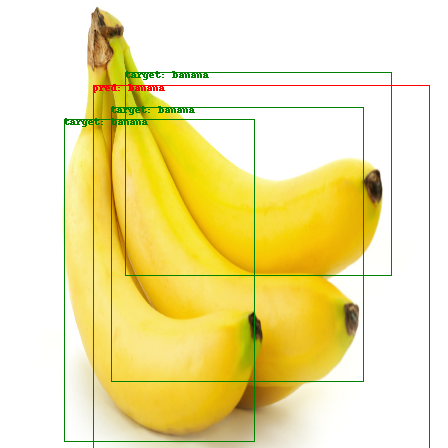

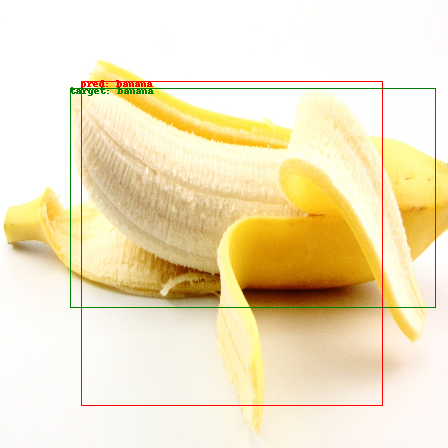

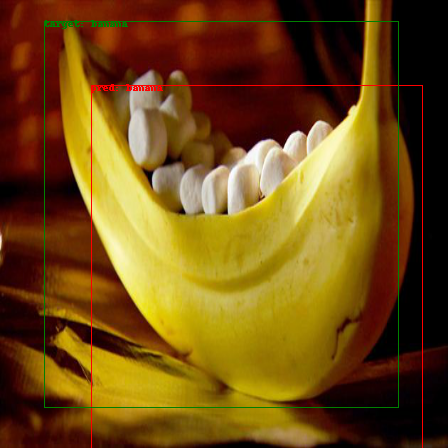

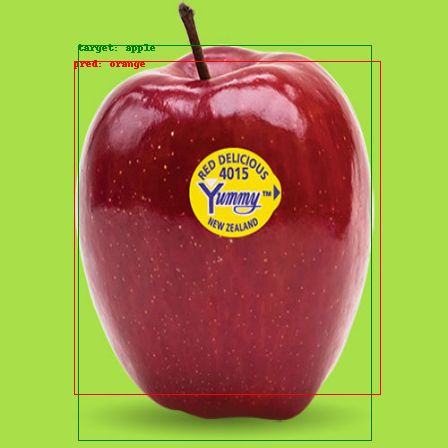

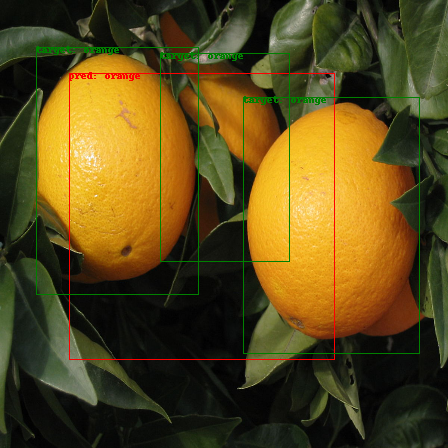

In [30]:
for i in [32, 27, 25, 8, 53]:
    vizualizer(i, val_dataset, test_pred_boxes, test_target_boxes)